In [102]:
# Goals
# > Predict who will buy 
# > Predict how much they spend

# Evaluation Methods
# > ROC/AUC
# > RMSE

############################################################
# GamePlan
# 1 Planning -> 2 Data Prep -> 3 Modeling -> 4 Followup

############################################################
# CODE STRUCTURE

# BLOCK 1: IMPORTS
# BLOCK 2: 
# BLOCK 3: 
# BLOCK 4: 
# BLOCK 5: 
# BLOCK 6: 
# BLOCK 7: 
# BLOCK 8: 
# BLOCK 9: 

In [103]:
# BLOCK 1: IMPORTS

# Python Library Imports 
import pandas as pd  # for Dataframes
import numpy as np  # for arrays
import matplotlib.pyplot as plt  # for plotting visuals

import xgboost as xgb  # boosted decision trees
import pandas_ml as pdml

import sklearn  # for machine learning
from sklearn import tree 
from sklearn import preprocessing

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from IPython.display import Image

import pickle # persistant objects aka classifier after training

from collections import Counter
from sklearn.datasets import make_classification
import subprocess

from sklearn.datasets import load_svmlight_files
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error

# Jupyter Notebook Styling
pd.set_option('notebook_repr_html', True)
pd.set_option('max_columns', 50)
pd.set_option('max_colwidth', 40)
%matplotlib inline 

In [104]:
# BLOCK 2: DATA IMPORT

# Data Imports
dataframe_training = pd.read_csv('df_training_scholarjet.csv', index_col=0) # Training dataset
dataframe_holdout = pd.read_csv('df_holdout_scholarjet.csv', index_col=0)  # holdout dataset

# Reindex dataframes
dataframe_training.index = range(len(dataframe_all))  
dataframe_holdout.index = range(len(dataframe_holdout))  

In [105]:
# DATA CLEANING: DROPPING COLUMNS
def dropColumns(dataframe_all):
    try:
        dataframe_all.drop(["team"], axis=1, inplace=True) # low variance
        dataframe_all.drop(["accrole"], axis=1, inplace=True)
        dataframe_all.drop(["aov"], axis=1, inplace=True)
        dataframe_all.drop(["cuidshare"], axis=1, inplace=True)
        dataframe_all.drop(["numstores"], axis=1, inplace=True)
        dataframe_all.drop(["avgquoteprice"], axis=1, inplace=True)
        
        dataframe_all['currentstatus'].replace(to_replace=['In Progress', 'Inactive', 'Unconfirmed'], value='Enrolled', inplace=True)
    except:
        print("Already Deleted")
dropColumns(dataframe_training)
dropColumns(dataframe_holdout)

print('dataframe_training', dataframe_training.shape)
print('dataframe_holdout', dataframe_holdout.shape)

dataframe_training (28126, 177)
dataframe_holdout (30375, 175)


In [106]:
# BLOCK : DATA ANALYSIS - PUREMEAN OF ENTIRE POPULATION

# Find and save the puremean of the dataset
def puremeanFunction(dataframe_all):
    
    # Examine entire dataset to find percent of buyers to total
    buyersDf = dataframe_all['revenue_30'] > 0
    buyersDf = dataframe_all[buyersDf]
    print(len(buyersDf), "out of a total of", len(dataframe_all), "bought" )
    print("{:.2%}".format(len(buyersDf) / len(dataframe_all)), "of all customers bought/converted")
    print("The average a customer spent was:", "${:,.2f}".format(buyersDf["revenue_30"].sum().round(2)))
    print("The average a customer spent was:", "${:.2f}".format(buyersDf["revenue_30"].sum().round(2)/len(buyersDf)))
    print("The average a population spends per person (buyers and non) was:", "${:.2f}".format(buyersDf["revenue_30"].sum().round(2)/len(dataframe_all)))
    print("The total this population can spend:", "${:,.2f}".format(buyersDf["revenue_30"].sum().round(2)/len(buyersDf)*len(dataframe_all)))

    # The mean score used for all those shitty small categories
    pureMean = len(buyersDf) / len(dataframe_all)

    print("Puremean =", pureMean)
    
    return pureMean, buyersDf

pureMean, buyersDf = puremeanFunction(dataframe_training)


2928 out of a total of 28126 bought
10.41% of all customers bought/converted
The average a customer spent was: $2,110,546.84
The average a customer spent was: $720.82
The average a population spends per person (buyers and non) was: $75.04
The total this population can spend: $20,273,647.69
Puremean = 0.10410296522790301


In [107]:
# BLOCK 4: DATA CLEANING

# Made a function that returns a dataframe of all the categorical columns in the dataset
# It produces a dataframe that has in 

# Statistics in dataframe: analysisDf
# 1. Total Count of each unique category
# 2. Total number that Bought in unique category
# 3. Total Revenue from those customers in unique category
# 4. #2 / #1 = % population of unique category that bought
def analysisDf(dataframe_all):
    df_shape = dataframe_all.shape
    
    # Find all categorical columns in columns dataframe and save in var: categorical_data_list
    categorical_data_list = []
    
    for cat in range(df_shape[1]):
        if dataframe_all.dtypes[cat] == 'object':
            categorical_data_list.append(dataframe_all.columns[cat])

    # Analyze the categorical data by finding Totals in each Unique categories
    # 1. Total Count of each unique category
    # 2. Total number that Bought in unique category
    # 3. Total Revenue from those customers in unique category
    # 4. #2 / #1 = % population of unique category that bought
    def categoricalAnalysis(df, categList, convert, revenue):
        categ_list_len = len(categList)

        # lists to add to the returned dataframe
        categTotals = []
        categConvert = []
        categRevenues = []
        percentBuy = []

    #     for all of the categorical columns
        for cat in range(categ_list_len):
            categTotalsd = {}
            categConvertd = {}
            categRevenuesd = {}
            percentBuyd = {}

            for index in range(len(df[categList[cat]].unique())):
                uniqueCat = df[categList[cat]].unique()[index]  # uniqueCat = iterates through actual unique category list

                categTotalsd[uniqueCat] = df[categList[cat]].value_counts()[uniqueCat]  # totals in cat

                #Convert for each cat
                tempDfcon = (df[convert]>0) & (df[categList[cat]] == uniqueCat)
                dfConvert = df[tempDfcon]
                categConvertd[uniqueCat] = dfConvert[convert].sum().round(2)            

                #Revenues for each cat
                tempDf = (df[revenue]>0) & (df[categList[cat]] == uniqueCat)
                dfUniqueAbove0 = df[tempDf]
                categRevenuesd[uniqueCat] = dfUniqueAbove0[revenue].sum().round(2)

                percentBuyd[uniqueCat] = categConvertd[uniqueCat] / categTotalsd[uniqueCat] 

    #         append to lists     
            categTotals.append(categTotalsd)    
            categConvert.append(categConvertd)
            categRevenues.append(categRevenuesd)
            percentBuy.append(percentBuyd)
        d = {'CatColumns':categTotals, 'UniqueCat':categConvert, 'RevCat':categRevenues, 'PercentBuy':percentBuy}
        categorical_data_df = pd.DataFrame(d)
        return categorical_data_df, categList

    # call function to create new dataframe of all the raw info on categoricals
    analysisDf, categList = categoricalAnalysis(dataframe_all, categorical_data_list, "convert_30", "revenue_30")   

    def printForCatAna():
        print("Categorical Data Columns in Dataframe:")
        print(categList)    
        print()
        print("Statistics in dataframe: analysisDf")
        print("1. Total Count of each unique category")
        print("2. Total number that Bought in unique category")
        print("3. Total Revenue from those customers in unique category")
        print("4. #2 / #1 = % population of unique category that bought")

    printForCatAna()

    return analysisDf, categList
analysisDf, categList = analysisDf(dataframe_training)

Categorical Data Columns in Dataframe:
['roll_up', 'currentstatus', 'companytypegroup', 'customersource', 'num_employees', 'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']

Statistics in dataframe: analysisDf
1. Total Count of each unique category
2. Total number that Bought in unique category
3. Total Revenue from those customers in unique category
4. #2 / #1 = % population of unique category that bought


In [108]:
# BLOCK 6: DATA CLEANING 

# Use dataframe created in function above to replace categories with their % of positive buyer
def useAnalysisDf(dataframe_all, categList, analysisDf, pureMean):
    #input mean scores into categories
    #for all examples where the data has less than 100 in the categories, input the pureMean
    def replaceCategCols(df, analysisDf, categorical_data_list):
        replaceDf = pd.DataFrame(df, copy=True)
        for i, cat in enumerate(categList):
            for j, unique in enumerate (replaceDf[cat].unique()):
                if (analysisDf.values[i][0][unique]< 100):
                    replaceDf[cat].replace(unique, pureMean,inplace=True)
                else:
                    replaceDf[cat].replace(unique, analysisDf.values[i][3][unique],inplace=True)
        return replaceDf      
    try:
        dataframe_all = pd.DataFrame(replaceCategCols(dataframe_all, analysisDf, categList), copy = True)
        print('Log 8: replaced categorical columns with their means')
        print(categList)
    except:
        print('Log 8: SKIPPED - replaced categorical columns with their means')
        print(categList)
    return dataframe_all
dataframe_training = useAnalysisDf(dataframe_training, categList, analysisDf, pureMean)
dataframe_holdout = useAnalysisDf(dataframe_holdout, categList, analysisDf, pureMean)
print(dataframe_holdout['currentstatus'].unique())
print(dataframe_training['currentstatus'].unique())
# analysisDf.values[1][0]

Log 8: replaced categorical columns with their means
['roll_up', 'currentstatus', 'companytypegroup', 'customersource', 'num_employees', 'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']
Log 8: replaced categorical columns with their means
['roll_up', 'currentstatus', 'companytypegroup', 'customersource', 'num_employees', 'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']
[0.0674978 0.1713047]
[0.1713047 0.0674978]


In [109]:
# Data Cleaning - *** Run Once
def fillNaNs(dataframe_all):
    dataframe_all.fillna(-0.1, inplace=True)
    
fillNaNs(dataframe_training)
fillNaNs(dataframe_holdout)


In [110]:
# DATA CLEANING: AGGREGATE FEATURES INTO ONE FUNCTION

# Function that takes in a dataframe, a string, and a list of strings. 
# It outs a changed dataframe
# the list of strings = colList has its rows added together and summed.
# those rows are then deleted
# a new row is added to the dataframe of string name = sumList
# and the summations of the rows are inputed into that category

#This function is a dimensional reduction tool
def summation(df, sumList, colList):    
    insLoc = 0  # var to hold location of colList
    try:
        insLoc = df.columns.get_loc(colList[0])
        print('setLocation', sumList, insLoc)
    except:
        pass

    def summateRows(df, sumList, colList): # this is a function to reduce time series features. Things such as numorderone, numorderthreeone etc. 
        # this can be reduced to make it easier for the algorithm to understand. There are currently 180 somethign features. That is too many for this amount of dataset
        # some quick math on the subject is 28126/185. I want maybe 40 features max. Ok summation
        addList = [] # list to hold the summations of the time series data. 
        try: 
            for i in range(len(df)): # for each data-row in the dataset
                sum = 0 # <-come back to the sum 
                for colIndex in range(len(colList)): # add the data from the rows we want to sum up
                    sum += df[colList[colIndex]].iloc[i] # increment for each
                addList.append(sum) # append it to the sum variable initialized above, then return this list at the end
        except: 
            print("log1: Unable to add sums from: ", colList)

        # make a function to drop the now aggregated lists
        def dropMultipleColumns(df, colList): # function
            try: # try and see if they have already been dropped because we ran the function previously in the session
                for col in colList: # for each column in the list 
                    df.drop(colList, axis=1, inplace=True)
                    print("log2: Deleting columns:", colList)
            except:
                print("log2: Already Deleted columns:", colList)
        
        dropMultipleColumns(df, colList)
        return addList 
    
    addList = summateRows(df, sumList, colList)
        
#     add this list into the dataframe
    # add column 
    try:
#         print (addList)
        df.insert(insLoc, sumList, addList)
        print("log3: Inserting:", sumList)
    except:
        loci = df.columns.get_loc(sumList)
        print("log3: Already Inserted:", sumList, " at index:", loci)
        print('~Added Column:', sumList)
        print('~Summation of columnList:', colList)
    return df # not that returning this will matter, its changed on the orinal dataframe param input

# Function to make it faster to add the list of columns to sum
def makeSumList(dataframe_all, firstCol, numColToRight):
    makeSumList = []
    try:
        firstColLoc = dataframe_all.columns.get_loc(firstCol)  
        for i in range(numColToRight):
            makeSumList.append(dataframe_all.columns[firstColLoc+i])
    except:
        makeSumList.append(firstCol)
    return makeSumList


In [111]:
def summationCaller(dataframe_all):
    # Feature: Orders
    summation(dataframe_all, 'orderrecent', makeSumList(dataframe_all, 'numorderone', 4))
    summation(dataframe_all, 'orderfar', makeSumList(dataframe_all, 'numordersixtythirty', 2))
    summation(dataframe_all, 'sumrevrecent', makeSumList(dataframe_all, 'sumrevone', 4))
    summation(dataframe_all, 'sumrevfar', makeSumList(dataframe_all, 'sumrevsixtythirty', 2))
    summation(dataframe_all, 'infl', makeSumList(dataframe_all, 'numinf', 4))

    # Feature: Satisfaction
    summation(dataframe_all, 'percdirtysum', makeSumList(dataframe_all, 'percdirtythirty', 3))
    summation(dataframe_all, 'issues', makeSumList(dataframe_all, 'numbilling', 5))

    # Feature: Quote
    summation(dataframe_all, 'numquotes', makeSumList(dataframe_all, 'numquote', 2))

    # Feature: Visit
    summation(dataframe_all, 'visitClose', makeSumList(dataframe_all, 'numvisitone', 4))
    summation(dataframe_all, 'visitFar', makeSumList(dataframe_all, 'numvisitsixtythirty', 2))
    summation(dataframe_all, 'numloggedClose', makeSumList(dataframe_all, 'numloggedinone', 4))
    summation(dataframe_all, 'numloggedFar', makeSumList(dataframe_all, 'numloggedinsixtythirty', 2))
    summation(dataframe_all, 'numseconsiteClose', makeSumList(dataframe_all, 'numsecondsonsiteone', 4))
    summation(dataframe_all, 'numseconsiteFar', makeSumList(dataframe_all, 'numsecondsonsitesixtythirty', 2))
    summation(dataframe_all, 'numtotalpageviewClose', makeSumList(dataframe_all, 'numtotalpageviewsone', 4))
    summation(dataframe_all, 'numtotalpageviewFar', makeSumList(dataframe_all, 'numtotalpageviewssixtythirty', 2))

    summation(dataframe_all, 'numatClose', makeSumList(dataframe_all, 'numatcone', 4))
    summation(dataframe_all, 'numatFar', makeSumList(dataframe_all, 'numatcsixtythirty', 2))
    summation(dataframe_all, 'numideaboardClose', makeSumList(dataframe_all, 'numideaboardone', 4))
    summation(dataframe_all, 'numideaboardFar', makeSumList(dataframe_all, 'numideaboardsixtythirty', 2))
    summation(dataframe_all, 'numtotalpageviewFar', makeSumList(dataframe_all, 'numtotalpageviewssixtythirty', 2))

    # Feature: Search
    summation(dataframe_all, 'searchClose', makeSumList(dataframe_all, 'numsearchtermsone', 4))
    summation(dataframe_all, 'searchFar', makeSumList(dataframe_all, 'numsearchtermssixtythirty', 2))

    # Feature: SKU
    summation(dataframe_all, 'numskuview', makeSumList(dataframe_all, 'numskusviewedone', 6))
    summation(dataframe_all, 'avgprice', makeSumList(dataframe_all, 'avgpriceone', 6))

    # Feature: Task
    summation(dataframe_all, 'numtasksfirstintro', makeSumList(dataframe_all, 'numtasksfirstintroone', 6))
    summation(dataframe_all, 'numtaskscadence', makeSumList(dataframe_all, 'numtaskscadenceone', 6))
    summation(dataframe_all, 'numtasksreassign', makeSumList(dataframe_all, 'numtasksreassignone', 6))
    summation(dataframe_all, 'numtaskscustact', makeSumList(dataframe_all, 'numtaskscustactone', 6))
    summation(dataframe_all, 'numtasksother', makeSumList(dataframe_all, 'numtasksotherone', 6))

    # Feature: Call
    summation(dataframe_all, 'numcallsClose', makeSumList(dataframe_all, 'numcallsone', 4))
    summation(dataframe_all, 'numcallsFar', makeSumList(dataframe_all, 'numcallssixtythirty', 2))

    # Feature: Email - BAM
    summation(dataframe_all, 'numemailsClose', makeSumList(dataframe_all, 'numemailsone', 4))
    summation(dataframe_all, 'numemailsFar', makeSumList(dataframe_all, 'numemailssixtythirty', 2))

    # Feature: Call
    summation(dataframe_all, 'totalcalldurationClose', makeSumList(dataframe_all, 'totalcalldurationone', 2))
    summation(dataframe_all, 'totalcalldurationFar', makeSumList(dataframe_all, 'totalcalldurationsixtythirty', 2))
    summation(dataframe_all, 'decmakerflag', makeSumList(dataframe_all, 'decmakerflagone', 4))

    # Feature: Email
    summation(dataframe_all, 'percemailopenedClose', makeSumList(dataframe_all, 'percemailopenedone', 4))
    summation(dataframe_all, 'percemailopenedFar', makeSumList(dataframe_all, 'percemailopenedsixtythirty', 2))
    summation(dataframe_all, 'percemailclickedClose', makeSumList(dataframe_all, 'percemailclickedone', 4))
    summation(dataframe_all, 'percemailclickedFar', makeSumList(dataframe_all, 'percemailclickedsixtythirty', 2))

    return dataframe_all

summationCaller(dataframe_training)
summationCaller(dataframe_holdout)    

dataframe_training

setLocation orderrecent 11
log2: Deleting columns: ['numorderone', 'numorderthreeone', 'numorderseventhree', 'numorderthirtyseven']
log2: Already Deleted columns: ['numorderone', 'numorderthreeone', 'numorderseventhree', 'numorderthirtyseven']
log3: Inserting: orderrecent
setLocation orderfar 12
log2: Deleting columns: ['numordersixtythirty', 'numorderyearsixty']
log2: Already Deleted columns: ['numordersixtythirty', 'numorderyearsixty']
log3: Inserting: orderfar
setLocation sumrevrecent 13
log2: Deleting columns: ['sumrevone', 'sumrevthreeone', 'sumrevseventhree', 'sumrevthirtyseven']
log2: Already Deleted columns: ['sumrevone', 'sumrevthreeone', 'sumrevseventhree', 'sumrevthirtyseven']
log3: Inserting: sumrevrecent
setLocation sumrevfar 14
log2: Deleting columns: ['sumrevsixtythirty', 'sumrevyearsixty']
log2: Already Deleted columns: ['sumrevsixtythirty', 'sumrevyearsixty']
log3: Inserting: sumrevfar
setLocation infl 20
log2: Deleting columns: ['numinf', 'numinfconnect', 'numinfphone

log2: Deleting columns: ['numtaskscustactone', 'numtaskscustactthreeone', 'numtaskscustactseventhree', 'numtaskscustactthirtyseven', 'numtaskscustactsixtythirty', 'numtaskscustactyearsixty']
log2: Already Deleted columns: ['numtaskscustactone', 'numtaskscustactthreeone', 'numtaskscustactseventhree', 'numtaskscustactthirtyseven', 'numtaskscustactsixtythirty', 'numtaskscustactyearsixty']
log3: Inserting: numtaskscustact
setLocation numtasksother 56
log2: Deleting columns: ['numtasksotherone', 'numtasksotherthreeone', 'numtasksotherseventhree', 'numtasksotherthirtyseven', 'numtasksothersixtythirty', 'numtasksotheryearsixty']
log2: Already Deleted columns: ['numtasksotherone', 'numtasksotherthreeone', 'numtasksotherseventhree', 'numtasksotherthirtyseven', 'numtasksothersixtythirty', 'numtasksotheryearsixty']
log3: Inserting: numtasksother
setLocation numcallsClose 57
log2: Deleting columns: ['numcallsone', 'numcallsthreeone', 'numcallsseventhree', 'numcallsthirtyseven']
log2: Already Delet

log2: Deleting columns: ['numideaboardone', 'numideaboardthreeone', 'numideaboardseventhree', 'numideaboardthirtyseven']
log2: Already Deleted columns: ['numideaboardone', 'numideaboardthreeone', 'numideaboardseventhree', 'numideaboardthirtyseven']
log3: Inserting: numideaboardClose
setLocation numideaboardFar 42
log2: Deleting columns: ['numideaboardsixtythirty', 'numideaboardyearsixty']
log2: Already Deleted columns: ['numideaboardsixtythirty', 'numideaboardyearsixty']
log3: Inserting: numideaboardFar
log1: Unable to add sums from:  ['numtotalpageviewssixtythirty']
log2: Already Deleted columns: ['numtotalpageviewssixtythirty']
log3: Already Inserted: numtotalpageviewFar  at index: 38
~Added Column: numtotalpageviewFar
~Summation of columnList: ['numtotalpageviewssixtythirty']
setLocation searchClose 46
log2: Deleting columns: ['numsearchtermsone', 'numsearchtermsthreeone', 'numsearchtermsseventhree', 'numsearchtermsthirtyseven']
log2: Already Deleted columns: ['numsearchtermsone', '

,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,customersource,num_employees,num_purchases_year,cost_purchases_year,enrollmentmethod,orderrecent,orderfar,sumrevrecent,sumrevfar,numbamorder,numselforder,totalrev,dayssincelastord,pospercentage,infl,percentlarge,percdirtysum,issues,percentresolved,...,searchFar,numskuview,avgprice,numtasksfirstintro,numtaskscadence,numtasksreassign,numtaskscustact,numtasksother,numcallsClose,numcallsFar,numemailsClose,numemailsFar,totalcalldurationClose,totalcalldurationseventhree,totalcalldurationthirtyseven,totalcalldurationFar,decmakerflag,percsecondsinbound,percemailopenedClose,percemailopenedFar,percemailclickedClose,percemailclickedFar,currentapplicability,numemaillist,dayssinceenrollment
0,20,0,0.00,0.149810,0.171305,0.099921,0.116755,0.143836,0.118812,0.104143,0.119595,1.0,0.0,59.99,0.00,0.0,1.0,59.99,17,0.000000,0.0,0.000000,0.000000,-0.5,-0.1,...,2.0,36.0,179.926389,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,43.0,0.0,0.0,0.000000,3.609524,0.000000,0.190476,0.000000,3.000000,1.0,17
1,57,0,0.00,0.149810,0.171305,0.099921,0.113887,0.132339,0.133682,0.148094,0.119595,0.0,1.0,0.00,126.48,0.0,1.0,126.48,62,0.000000,0.0,0.000000,0.000000,-0.5,-0.1,...,19.0,82.0,509.668537,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,55.0,0.0,78.0,0.0,0.000000,0.080000,0.020000,0.040000,0.020000,3.000000,1.0,70
2,163,0,0.00,0.149810,0.171305,0.099921,0.113887,0.144372,0.123443,0.142373,0.119595,1.0,0.0,237.98,0.00,0.0,1.0,237.98,27,0.000000,0.0,0.000000,0.000000,-0.5,-0.1,...,1.0,38.0,694.247105,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.000000,0.363636,0.192402,0.000000,0.001770,13.000000,1.0,27
3,167,0,0.00,0.149810,0.067498,0.099921,0.104120,0.143836,0.123443,0.104143,0.119595,-0.4,-0.2,-0.40,-0.20,-0.1,-0.1,-0.10,1000,-0.100000,-0.4,-0.100000,-0.300000,-0.5,-0.1,...,3.0,28.0,158.152857,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,67.0,41.0,0.0,0.000000,1.000000,0.100000,0.000000,0.100000,-0.100000,-0.1,25
4,168,0,0.00,0.149810,0.067498,0.099921,0.104103,0.129032,0.162031,0.137265,0.119595,-0.4,-0.2,-0.40,-0.20,-0.1,-0.1,-0.10,1000,-0.100000,-0.4,-0.100000,-0.300000,-0.5,-0.1,...,10.0,21.0,93.175714,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,50.0,35.0,0.0,0.000000,0.097619,0.130896,0.009524,0.020272,8.333333,3.0,33
5,215,0,0.00,0.149810,0.067498,0.099921,0.113887,0.092455,0.094511,0.094721,0.119595,-0.4,-0.2,-0.40,-0.20,-0.1,-0.1,-0.10,1000,-0.100000,-0.4,-0.100000,-0.300000,-0.5,-0.1,...,5.0,56.0,394.651071,-0.6,-0.6,-0.6,-0.6,-0.6,-0.4,-0.2,-0.4,-0.2,-0.2,-0.1,-0.1,-0.2,-0.4,-0.100000,1.166667,0.556009,0.500000,0.093654,1.000000,1.0,2
6,285,0,0.00,0.149810,0.067498,0.099921,0.104120,0.092455,0.094511,0.094721,0.133648,-0.4,-0.2,-0.40,-0.20,-0.1,-0.1,-0.10,1000,-0.100000,-0.4,-0.100000,-0.300000,-0.5,-0.1,...,5.0,101.0,558.136139,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,172.0,0.0,-0.100000,0.000000,0.000000,0.333333,0.111111,0.000000,1.0,99
7,363,1,323.97,0.149810,0.171305,0.099921,0.116755,0.144372,0.133682,0.137265,0.119595,0.0,2.0,0.00,3631.55,0.0,2.0,3631.55,38,0.000000,2.0,0.000000,0.000000,1.0,1.0,...,230.0,1401.0,325.937009,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,387.0,0.0,-0.100000,0.223529,0.557540,0.023529,0.087250,8.333333,3.0,42
8,401,0,0.00,0.149810,0.171305,0.099921,0.113887,0.092455,0.094511,0.094721,0.078799,2.0,0.0,849.55,0.00,0.0,2.0,849.55,3,0.000000,0.0,0.000000,0.000000,-0.5,-0.1,...,2.0,94.0,451.654255,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,-0.100000,1.116667,0.281352,0.364394,0.064977,4.000000,2.0,35
9,421,0,0.00,0.149810,0.067498,0.099921,0.113887,0.092455,0.094511,0.094721,0.133648,-0.4,-0.2,-0.40,-0.20,-0.1,-0.1,-0.10,1000,-0.100000,-0.4,-0.100000,-0.300000,-0.5,-0.1,...,4.0,175.0,436.544171,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0,0.0,0.0,0.0,-0.100000,1.000000,0.000000,0.250000,0.000000,7.000000,1.0,0


In [180]:
# Pickle Cleaned Datasets

# CLEANED DATA LOADER

cleanedTrainingData = 'cleanedTrainingData.sav'
cleanedHoldoutData = 'cleanedHoldoutData.sav'

# pickle.dump(dataframe_training, open(cleanedTrainingData, 'wb'))
# pickle.dump(dataframe_holdout, open(cleanedHoldoutData, 'wb'))

dataframe_training = pickle.load(open(cleanedTrainingData, 'rb'))
dataframe_holdout = pickle.load(open(cleanedHoldoutData, 'rb'))



In [182]:
# # BLOCK 8: DATA SPLITTING
def dataSplittingTraining(dataframe_all):
    dataframe_all = sklearn.utils.shuffle(dataframe_all) #shuffle data
    try:
        cuid = pd.DataFrame(dataframe_all['cuid'], copy=True)
        dataframe_all.drop(['cuid'], axis=1, inplace=True)
        print("LOG: saving cuid")
    except:
        print("LOG: cuid already saved")
              
    try:          
        # Target variables for classification and regression
        yConv = pd.DataFrame(dataframe_all['convert_30'], copy=True)
        yRegr = pd.DataFrame(dataframe_all['revenue_30'], copy=True)
        # drop from dataframe
        dataframe_all.drop(['convert_30', 'revenue_30'], axis=1, inplace=True)
    except:
        pass          
              
    X = pd.DataFrame(dataframe_all, copy=True)
    
    seed = 100 # for consistancy

    # Classification training set
    X_train_convert, X_test_convert, y_train_convert, y_test_convert = train_test_split(X, yConv, test_size=0.2, random_state=seed)
              
    # Regression training set
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, yRegr, test_size=0.2, random_state=seed)

    return X_train_convert, X_test_convert, y_train_convert, y_test_convert, X_train_reg, X_test_reg, y_train_reg, y_test_reg
X_train_convert, X_test_convert, y_train_convert, y_test_convert, X_train_reg, X_test_reg, y_train_reg, y_test_reg = dataSplittingTraining(dataframe_training)            



C:\Users\alecc\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


LOG: saving cuid


In [200]:
# MODELING: XGB CLASSIFIER

model_convert = XGBClassifier(scale_pos_weight=4)
print(model_convert)

eval_set = [(X_test_convert, y_test_convert)]

model_convert.fit(X_train_convert, y_train_convert, early_stopping_rounds=5, eval_metric="auc", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=4, seed=None, silent=None,
       subsample=1, verbosity=1)


C:\Users\alecc\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alecc\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alecc\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=4, seed=None, silent=None,
       subsample=1, verbosity=1)

In [184]:
# Predict from the test data into array of percentages from 0 to 1
y_pred_convert = model_convert.predict(X_test_convert)

#percentages 0-.5 round to 0 else round to 1
predictions = [round(value) for value in y_pred_convert]
# compare to actual
accuracy = accuracy_score(y_test_convert, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.93%


C:\Users\alecc\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [185]:
y_test_preds = (model_convert.predict(X_test_convert) > 0.5).astype('int')
yt = y_test_convert['convert_30'].values

pd.crosstab(
    pd.Series(yt, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

C:\Users\alecc\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted,0,1,All
Actual,,,
0,4428,626,5054
1,278,294,572
All,4706,920,5626


In [235]:
try:
    cuid = pd.DataFrame(dataframe_holdout['cuid'], copy=True)
    dataframe_holdout.drop(['cuid'], axis=1, inplace=True)
except:
    pass

holdoutConversionPredictionPercentages = model_convert.predict_proba(dataframe_holdout)

# print(len(holdoutConversionPredictionPercentages))


# print(holdoutConversionPredictionPercentages[:20])
# holdoutConversionPredictionPercentages[i][1]

predictionConvertList = []
for i in range(len(holdoutConversionPredictionPercentages)):
    predictionConvertList.append(holdoutConversionPredictionPercentages[i][1])

# dataframe_predictions = pd.DataFrame(cuid, predictionConvertList)
# # pd.DataFrame([])    
# #     predictionConvertList
# dataframe_predictions

cuid['pred_convert_30'] = predictionConvertList
# cuid

In [240]:
model_regr = XGBRegressor()

eval_set = [(X_test_reg, y_test_reg)]
model_regr.fit(X_train_reg, y_train_reg, early_stopping_rounds=5, eval_metric="rmse", eval_set=eval_set, verbose=False)



[21:33:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [239]:
y_predr = model_regr.predict(X_test_reg)

#percentages 0-.5 round to 0 else round to 1
predictionsr = [round(value) for value in y_predr]

rmse = np.sqrt(mean_squared_error(y_test_reg, predictionsr))
print("RMSE: %f" %(rmse))


RMSE: 417.207826


In [254]:
holdoutRegressionPredictionRevenue = model_regr.predict(dataframe_holdout)

len(holdoutRegressionPredictionRevenue)
cuid['pred_revenue_30'] = holdoutRegressionPredictionRevenue
# cuid

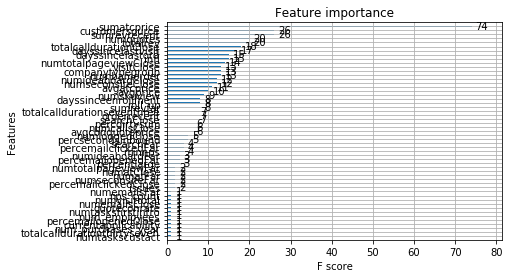

In [256]:
xgb.plot_importance(model_regr)

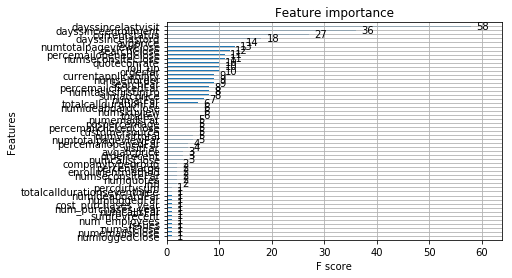

In [258]:
xgb.plot_importance(model_convert)

In [264]:
from pandas import DataFrame

export_csv = cuid.to_csv ('AlecJames-BringingDataHome-Scholarjet-Competition.csv', index = None, header=True)